# Cortisol Analysis

In [1]:
from pathlib import Path
import json

import pandas as pd
import numpy as np
import pingouin as pg

import biopsykit as bp
from biopsykit.stats import StatsPipeline
from biopsykit.io import load_long_format_csv
from biopsykit.utils.dataframe_handling import multi_xs

from fau_colors import cmaps

import matplotlib.pyplot as plt
import seaborn as sns

from carwatch_analysis.io import load_cortisol_samples_log_times
from carwatch_analysis.utils import describe_groups_df
from carwatch_analysis.stats import create_unique_night_id
from carwatch_analysis.plotting import multi_paired_plot_auc, paired_plot_auc


%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties)

theme_kwargs = {"context": "talk", "style": "ticks", "palette": palette}
theme_kwargs_grid = {"context": "talk", "style": "ticks", "palette": palette, "font_scale": 0.8}
sns.set_theme(**theme_kwargs)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

export = True

pg.options["round"] = 4

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

## Setup Paths

In [3]:
base_path = Path("../..")
export_path = base_path.joinpath("exports")
result_path = base_path.joinpath("results")
stats_path = result_path.joinpath("statistics")

img_path = result_path.joinpath("plots")

paper_path = Path(json.load(Path("../paper_path.json").open(encoding="utf-8"))["paper_path"])
paper_img_path = paper_path.joinpath("img")

bp.utils.file_handling.mkdirs([result_path, stats_path, img_path, paper_img_path])

## Load Data

### Cortisol Samples

In [4]:
cort_path = export_path.joinpath("cortisol_samples_processed_all_log_types.csv")
cort_samples = load_cortisol_samples_log_times(cort_path)

cort_samples.head()

date      wake_onset  \
subject night night_id condition   log_type sample                              
AB19E   0     AB19E_0  Known Alarm Naive    S0     2019-11-18 0 days 05:45:00   
                                            S1     2019-11-18 0 days 05:45:00   
                                            S2     2019-11-18 0 days 05:45:00   
                                            S3     2019-11-18 0 days 05:45:00   
                                            S4     2019-11-18 0 days 05:45:00   

                                                       sample_time  cortisol  \
subject night night_id condition   log_type sample                             
AB19E   0     AB19E_0  Known Alarm Naive    S0     0 days 05:45:00      2.80   
                                            S1     0 days 06:00:00      5.59   
                                            S2     0 days 06:15:00     13.29   
                                            S3     0 days 06:30:00     13.46   
                                            S4     0 days 06:45:00     12.65   

                                                   time_diff_to_wake_onset  \
subject night night_id condition   log_type sample                           
AB19E   0     AB19E_0  Known Alarm Naive    S0             0 days 00:00:00   
                                            S1             0 days 00:15:00   
                                            S2             0 days 00:30:00   
                                            S3             0 days 00:45:00   
                                            S4             0 days 01:00:00   

                                                    time_diff_min  \
subject night night_id condition   log_type sample                  
AB19E   0     AB19E_0  Known Alarm Naive    S0                0.0   
                                            S1               15.0   
                                            S2               30.0   
                                            S3               45.0   
                                            S4               60.0   

                                                    time_diff_to_naive_min  
subject night night_id condition   log_type sample                          
AB19E   0     AB19E_0  Known Alarm Naive    S0                         0.0  
                                            S1                         0.0  
                                            S2                         0.0  
                                            S3                         0.0  
                                            S4                         0.0

### Cortisol Features

In [5]:
cort_features = load_long_format_csv(export_path.joinpath("cortisol_features_processed_all_log_types.csv"))
cort_features = create_unique_night_id(cort_features)
cort_features.head()

cortisol
subject night night_id condition   log_type saliva_feature          
AB19E   0     AB19E_0  Known Alarm Naive    auc_g            600.975
                                            auc_i            432.975
                                            ini_val            2.800
                                            max_inc           10.660
                                            max_val           13.460

In [6]:
# Don't consider IMU and IMU_App because the cortisol features are the same as
# Selfreport and App since only the wake onset differs, but not the sampling times
log_types_fine = [
    "Naive",
    "Selfreport without App",
    "Selfreport with App",
    "App",
    "Sensor + Selfreport without App",
    "Sensor + Selfreport with App",
    "Sensor + App",
]
log_types_coarse = ["Naive", "Selfreport", "App", "Sensor + Selfreport", "Sensor + App"]
delay_groups = ["None", "Short", "Moderate", "High"]

## Data Selection

### Cortisol Samples

In [7]:
cort_samples = multi_xs(cort_samples, log_types_fine, level="log_type")
cort_samples.head()

date      wake_onset  \
subject night night_id condition   log_type sample                              
AB19E   0     AB19E_0  Known Alarm Naive    S0     2019-11-18 0 days 05:45:00   
                                            S1     2019-11-18 0 days 05:45:00   
                                            S2     2019-11-18 0 days 05:45:00   
                                            S3     2019-11-18 0 days 05:45:00   
                                            S4     2019-11-18 0 days 05:45:00   

                                                       sample_time  cortisol  \
subject night night_id condition   log_type sample                             
AB19E   0     AB19E_0  Known Alarm Naive    S0     0 days 05:45:00      2.80   
                                            S1     0 days 06:00:00      5.59   
                                            S2     0 days 06:15:00     13.29   
                                            S3     0 days 06:30:00     13.46   
                                            S4     0 days 06:45:00     12.65   

                                                   time_diff_to_wake_onset  \
subject night night_id condition   log_type sample                           
AB19E   0     AB19E_0  Known Alarm Naive    S0             0 days 00:00:00   
                                            S1             0 days 00:15:00   
                                            S2             0 days 00:30:00   
                                            S3             0 days 00:45:00   
                                            S4             0 days 01:00:00   

                                                    time_diff_min  \
subject night night_id condition   log_type sample                  
AB19E   0     AB19E_0  Known Alarm Naive    S0                0.0   
                                            S1               15.0   
                                            S2               30.0   
                                            S3               45.0   
                                            S4               60.0   

                                                    time_diff_to_naive_min  
subject night night_id condition   log_type sample                          
AB19E   0     AB19E_0  Known Alarm Naive    S0                         0.0  
                                            S1                         0.0  
                                            S2                         0.0  
                                            S3                         0.0  
                                            S4                         0.0

### Cortisol Features

In [8]:
cort_features_analysis = cort_features.copy()
cort_features_analysis = multi_xs(cort_features_analysis, ["auc_g", "auc_i"], level="saliva_feature")
cort_features_analysis = multi_xs(cort_features_analysis, log_types_fine, level="log_type")
cort_features_analysis.head()

cortisol
subject night night_id condition   log_type                        saliva_feature          
AB19E   0     AB19E_0  Known Alarm Naive                           auc_g            600.975
                                                                   auc_i            432.975
                                   Selfreport without App          auc_g            614.030
                                                                   auc_i            443.230
                                   Sensor + Selfreport without App auc_g            614.030

## Saliva Samples – CAR Plot

In [9]:
log_types = ["Selfreport without App", "App"]

data_plot = cort_samples.reindex(log_types, level="log_type")

car = bp.protocols.CAR()
car.add_saliva_data(saliva_data=data_plot, saliva_type="cortisol", sample_times=[0, 15, 30, 45, 60])

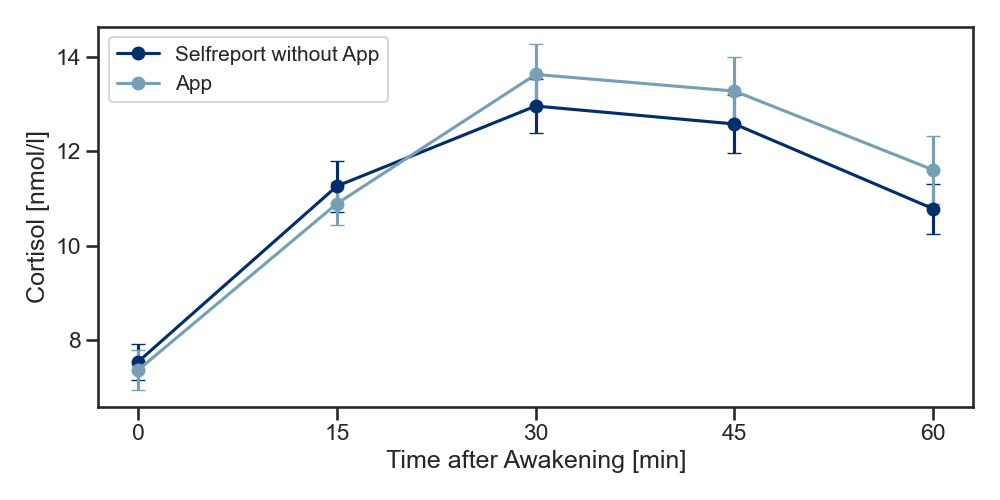

In [10]:
fig, ax = plt.subplots()

car.car_saliva_plot(
    saliva_type="cortisol",
    hue="log_type",
    style="log_type",
    # linestyle=["-", "--", "-.", ":"],
    # marker=["o", "P", "v", "s"],
    ax=ax,
    hue_order=log_types,
    x_offset=0.0,
)
fig.tight_layout()

In [28]:
dict_saliva_export = {}

## Saliva Features – Statistical Analysis

### Log Type

In [77]:
log_types = ["Naive", "Selfreport with App", "App"]

data_analysis = cort_features_analysis.reindex(log_types, level="log_type")

pipeline = StatsPipeline(
    steps=[("prep", "normality"), ("prep", "equal_var"), ("test", "rm_anova"), ("posthoc", "pairwise_tests")],
    params={
        "dv": "cortisol",
        "within": "log_type",
        "subject": "night_id",
        "groupby": "saliva_feature",
        "multicomp": {"method": "bonf", "levels": False},
    },
)

pipeline.apply(data_analysis)
pipeline.export_statistics(stats_path.joinpath("stats_auc_log_type.xlsx"))
pipeline.display_results()

<font size="3"><b> Overview </b></font>

,dv,within,subject,groupby,multicomp
parameter,cortisol,log_type,night_id,saliva_feature,"{'method': 'bonf', 'levels': False}"


,prep,prep,test,posthoc
parameter,normality,equal_var,rm_anova,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W    pval  normal
saliva_feature                                            
auc_g          Naive                0.9842  0.0217   False
               Selfreport with App  0.9878  0.5383    True
               App                  0.9873  0.6187    True
auc_i          Naive                0.9901  0.1767    True
               Selfreport with App  0.9918  0.8367    True
               App                  0.9898  0.7823    True

**Test for Homoscedasticity (Equal Variances)**

,,W,pval,equal_var
saliva_feature,,,,
auc_g,levene,0.2006,0.8183,True
auc_i,levene,0.6880,0.5032,True


<font size="3"><b> Statistical Tests </b></font>

**Repeated-measurement ANOVA**

,,Source,ddof1,ddof2,F,p-unc,ng2,eps,p-GG-corr,sphericity,W-spher,p-spher
saliva_feature,,,,,,,,,,,,
auc_g,0,log_type,2,154,67.1596,0.0,0.0012,0.9913,NaN,NaN,NaN,NaN
auc_i,0,log_type,2,154,24.5021,0.0,0.0001,0.8050,0.0,False,0.7578,0.0


<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

Contrast      A                    B  Paired  Parametric  \
saliva_feature                                                               
auc_g          0  log_type    App                Naive    True        True   
               1  log_type    App  Selfreport with App    True        True   
               2  log_type  Naive  Selfreport with App    True        True   
auc_i          0  log_type    App                Naive    True        True   
               1  log_type    App  Selfreport with App    True        True   
               2  log_type  Naive  Selfreport with App    True        True   

                        T   dof alternative   p-unc       BF10  hedges  p-corr  
saliva_feature                                                                  
auc_g          0  11.5934  77.0   two-sided  0.0000  3.737e+15  0.0852  0.0000  
               1   5.5990  77.0   two-sided  0.0000  4.358e+04  0.0395  0.0000  
               2  -5.9682  77.0   two-sided  0.0000  1.858e+05 -0.0462  0.0000  
auc_i          0   5.7577  77.0   two-sided  0.0000  8.093e+04  0.0291  0.0000  
               1   4.2771  77.0   two-sided  0.0001    355.376  0.0170  0.0003  
               2  -3.6470  77.0   two-sided  0.0005     47.509 -0.0122  0.0015

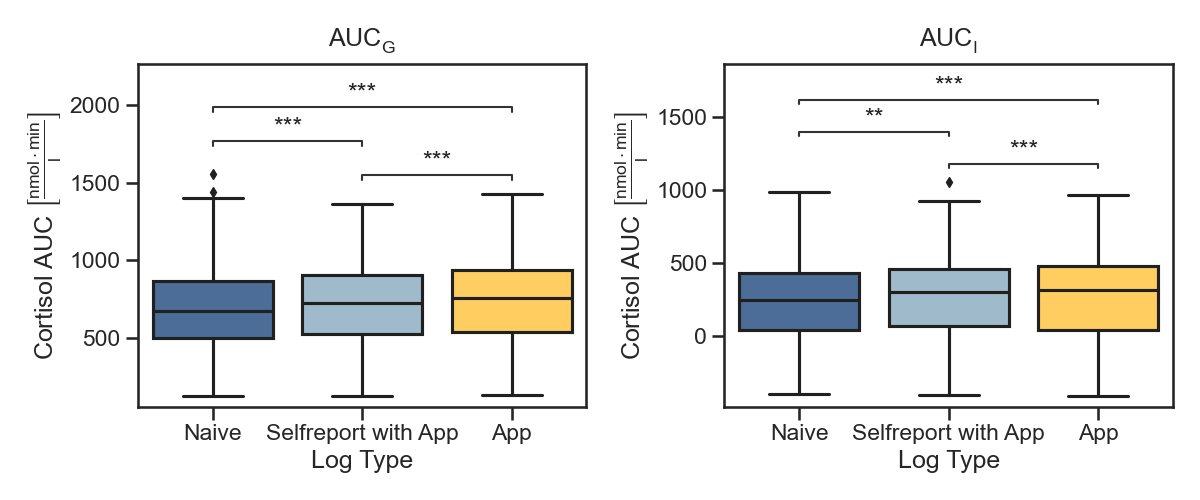

In [34]:
box_pairs, pvalues = pipeline.sig_brackets(
    "posthoc", stats_effect_type="within", plot_type="single", subplots=True, x="log_type", features=["auc_g", "auc_i"]
)

title_map = {"auc_g": "$AUC_G$", "auc_i": "$AUC_I$"}

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

for (feature, data), ax in zip(cort_features_analysis.groupby("saliva_feature"), axs):
    bp.protocols.plotting.saliva_feature_boxplot(
        data=data,
        x="log_type",
        saliva_type="cortisol",
        feature=feature,
        order=log_types,
        stats_kwargs={"box_pairs": box_pairs[feature], "pvalues": pvalues[feature], "verbose": 0},
        ax=ax,
    )
    ax.set_title(title_map[feature], pad=12)
    ax.set_xlabel("Log Type")
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.05)

fig.tight_layout()

for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_boxplot_auc", path, ["pdf", "png"], dpi=300)

### Interaction Condition x Log Type

In [35]:
log_types = ["Naive", "Selfreport with App", "App"]

data_analysis = cort_features_analysis.reindex(log_types, level="log_type")

pipeline = StatsPipeline(
    steps=[("prep", "normality"), ("prep", "equal_var"), ("test", "mixed_anova"), ("posthoc", "pairwise_tests")],
    params={
        "dv": "cortisol",
        "within": "log_type",
        "between": "condition",
        "subject": "night_id",
        "groupby": "saliva_feature",
        "multicomp": {"method": "bonf", "levels": None},
    },
)

pipeline.apply(data_analysis)
pipeline.display_results(prep=False, posthoc=False)

<font size="3"><b> Overview </b></font>

,dv,within,between,subject,groupby,multicomp
parameter,cortisol,log_type,condition,night_id,saliva_feature,"{'method': 'bonf', 'levels': None}"


,prep,prep,test,posthoc
parameter,normality,equal_var,mixed_anova,pairwise_tests


<font size="3"><b> Statistical Tests </b></font>

**Mixed ANOVA**

Source           SS  DF1  DF2           MS        F  \
saliva_feature                                                               
auc_g          0    condition  120564.8452    2   75   60282.4226   0.2643   
               1     log_type   21569.0145    2  150   10784.5072  66.7362   
               2  Interaction     489.4769    4  150     122.3692   0.7572   
auc_i          0    condition  957755.5346    2   75  478877.7673   1.8174   
               1     log_type    3031.7562    2  150    1515.8781  24.7505   
               2  Interaction     340.6112    4  150      85.1528   1.3903   

                   p-unc     np2     eps  p-GG-corr sphericity  W-spher  \
saliva_feature                                                            
auc_g          0  0.7685  0.0070     NaN        NaN        NaN      NaN   
               1  0.0000  0.4708  0.9913        NaN        NaN      NaN   
               2  0.5547  0.0198     NaN        NaN        NaN      NaN   
auc_i          0  0.1695  0.0462     NaN        NaN        NaN      NaN   
               1  0.0000  0.2481  0.8050        0.0      False   0.7578   
               2  0.2400  0.0358     NaN        NaN        NaN      NaN   

                  p-spher  
saliva_feature             
auc_g          0      NaN  
               1      NaN  
               2      NaN  
auc_i          0      NaN  
               1      0.0  
               2      NaN

### Paired Plots

TODO: replace this by the biopsykit implementation after publishing the latest release

In [36]:
def columnwise_difference(data: pd.DataFrame):
    cols = data.columns
    df = data.values
    r, c = np.triu_indices(df.shape[1], 1)
    new_cols = [cols[i] + " | " + cols[j] for i, j in zip(r, c)]
    return pd.DataFrame(df[:, c] - df[:, r], columns=new_cols, index=data.index)

#### $AUC_G$

In [49]:
data_increase = cort_features_analysis.reindex(log_types, level="log_type").xs("auc_g", level="saliva_feature")
data_increase = data_increase.unstack("log_type")["cortisol"].dropna()
data_increase = columnwise_difference(data_increase).round(2)
data_increase = data_increase > 0
data_increase = data_increase.apply(lambda df: df.value_counts(normalize=True) * 100)
data_increase = data_increase.reindex([True, False]).round(0)
data_increase.index.name = "increasing"
dict_saliva_export["AUC_G_Log_Type_Increase"] = data_increase
data_increase

,Naive | Selfreport with App,Naive | App,Selfreport with App | App
increasing,,,
True,62.0,96.0,79.0
False,38.0,4.0,21.0


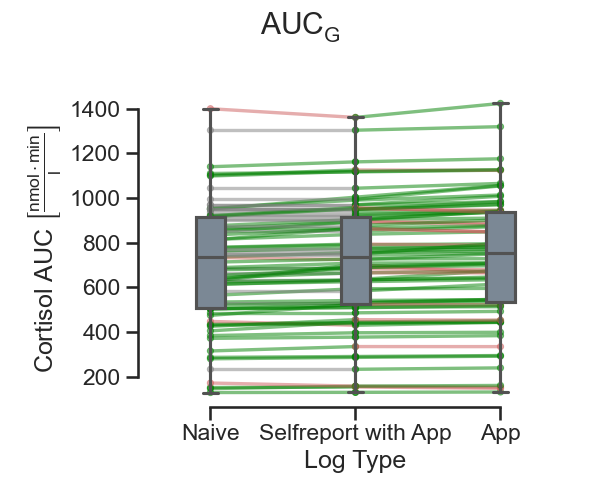

In [41]:
fig, ax = paired_plot_auc(data=cort_features_analysis, saliva_feature="auc_g", log_types=log_types, figsize=(6, 5))

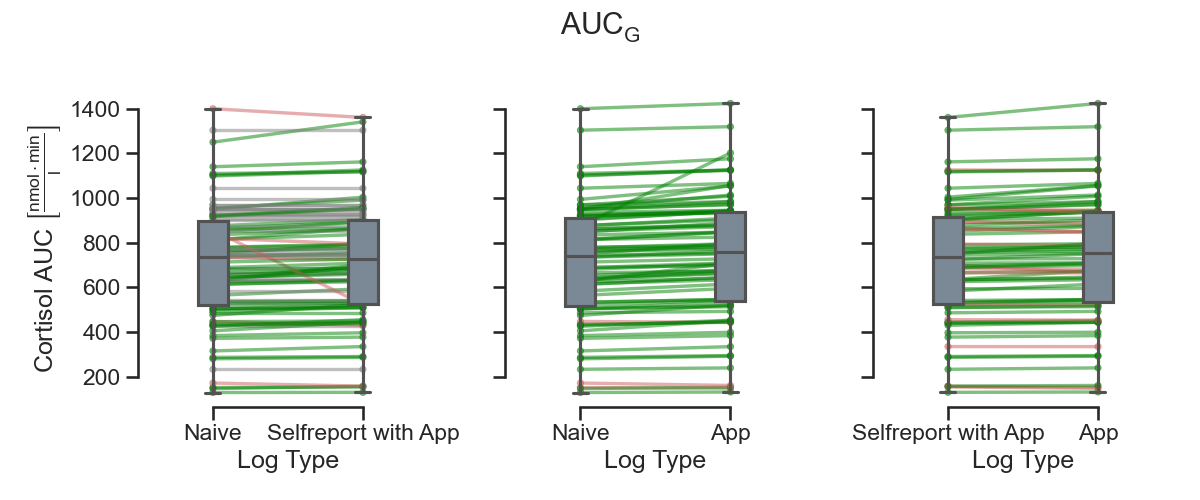

In [42]:
log_types = ["Naive", "Selfreport with App", "App"]

fig, axs = multi_paired_plot_auc(
    data=cort_features_analysis, saliva_feature="auc_g", log_types=log_types, figsize=(12, 5)
)

for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_pairedplot_aucg", path, ["pdf", "png"], dpi=300)

#### $AUC_I$

In [50]:
data_increase = cort_features_analysis.reindex(log_types, level="log_type").xs("auc_i", level="saliva_feature")
data_increase = data_increase.unstack("log_type")["cortisol"].dropna()
data_increase = columnwise_difference(data_increase).round(2)
data_increase = data_increase > 0
data_increase = data_increase.apply(lambda df: df.value_counts(normalize=True) * 100)
data_increase = data_increase.reindex([True, False]).round(0)
data_increase.index.name = "increasing"
dict_saliva_export["AUC_I_Log_Type_Increase"] = data_increase
data_increase

,Naive | Selfreport with App,Naive | App,Selfreport with App | App
increasing,,,
True,46.0,83.0,72.0
False,54.0,17.0,28.0


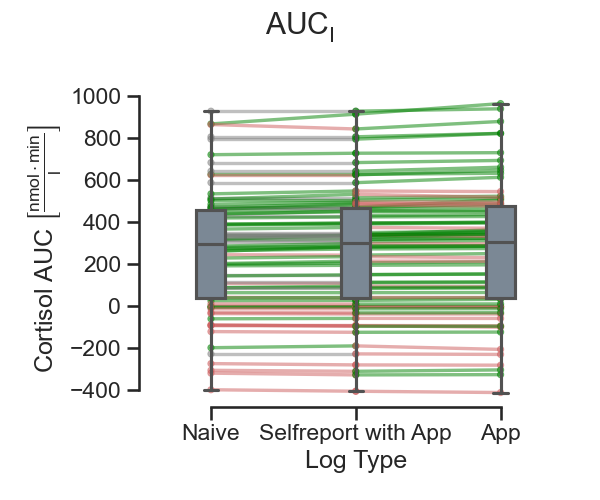

In [46]:
fig, ax = paired_plot_auc(data=cort_features_analysis, saliva_feature="auc_i", log_types=log_types, figsize=(6, 5))

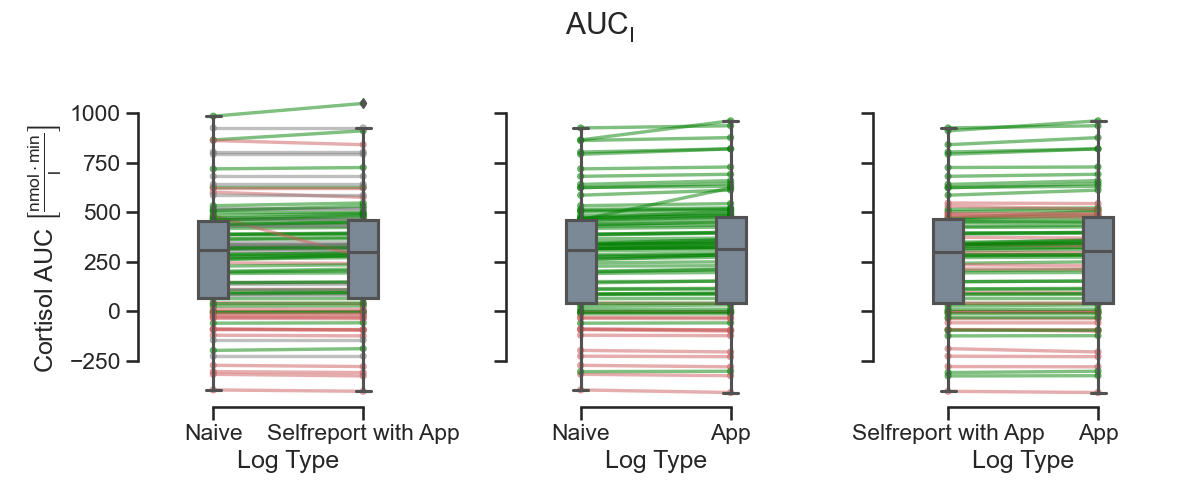

In [47]:
log_types = ["Naive", "Selfreport with App", "App"]

fig, axs = multi_paired_plot_auc(
    data=cort_features_analysis, saliva_feature="auc_i", log_types=log_types, figsize=(12, 5)
)

for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_pairedplot_auci", path, ["pdf", "png"], dpi=300)

### Increase vs. S2 Time Delay

(Kudielka et al. 2003):  
"We found that the larger the time deviation for sample 2 (+30 min), the smaller the observed awakening cortisol increase. If subjects delay sample 2, they obviously miss the peak, and the resulting awakening increase turns out to be smaller."

#### Data Preparation

Get time deviation for S2 (+30 min)

In [78]:
s2_delay = cort_samples.xs("S2", level="sample")[["time_diff_to_naive_min"]].dropna()

# drop time deviation outlier, i.e., samples that are be closer to S3 or to S1 than S2 (|delay| >= 7.5 min)
# drop_mask = s2_delay["time_diff_to_naive_min"].abs() >= 7.5
# drop_mask = drop_mask[drop_mask]
# s2_delay = s2_delay.drop(drop_mask.index)
s2_delay.columns = ["s2_delay"]

s2_delay.head()

s2_delay
subject night night_id condition   log_type                                  
AB19E   0     AB19E_0  Known Alarm Naive                             0.000000
                                   Selfreport without App           15.000000
                                   Sensor + Selfreport without App   3.133333
AB31R   0     AB31R_0  Spontaneous Naive                             0.000000
                                   Selfreport without App            5.000000

Get cortisol increase between S0 and S2

In [84]:
cort_inc = cort_samples[["cortisol"]]
cort_inc = cort_inc.xs("S2", level=-1) - cort_inc.xs("S0", level=-1)
cort_inc = cort_inc.join(s2_delay).dropna()
cort_inc.head()

cortisol  \
subject night night_id condition   log_type                                    
AB19E   0     AB19E_0  Known Alarm Naive                               10.49   
                                   Selfreport without App              10.49   
                                   Sensor + Selfreport without App     10.49   
AB31R   0     AB31R_0  Spontaneous Naive                                0.13   
                                   Selfreport without App               0.13   

                                                                     s2_delay  
subject night night_id condition   log_type                                    
AB19E   0     AB19E_0  Known Alarm Naive                             0.000000  
                                   Selfreport without App           15.000000  
                                   Sensor + Selfreport without App   3.133333  
AB31R   0     AB31R_0  Spontaneous Naive                             0.000000  
                                   Selfreport without App            5.000000

#### Linear Regression

In [85]:
data_grp = cort_inc.groupby("log_type")

data_result = {}

for log_type in ["Selfreport without App", "App", "Sensor + App"]:
    data_reg = data_grp.get_group(log_type)
    reg = pg.regression.linear_regression(
        X=data_reg["s2_delay"],
        y=data_reg["cortisol"],
    )
    data_result[log_type] = reg

pd.concat(data_result)

names    coef      se       T    pval      r2  \
Selfreport without App 0  Intercept  6.0774  0.6865  8.8526  0.0000  0.0223   
                       1   s2_delay -0.1641  0.1093 -1.5017  0.1364  0.0223   
App                    0  Intercept  6.3149  0.8967  7.0423  0.0000  0.0001   
                       1   s2_delay -0.0186  0.1801 -0.1033  0.9180  0.0001   
Sensor + App           0  Intercept  8.7163  2.1896  3.9807  0.0003  0.0239   
                       1   s2_delay -0.3157  0.3231 -0.9770  0.3346  0.0239   

                          adj_r2  CI[2.5%]  CI[97.5%]  
Selfreport without App 0  0.0124    4.7152     7.4396  
                       1  0.0124   -0.3808     0.0527  
App                    0 -0.0127    4.5297     8.1001  
                       1 -0.0127   -0.3771     0.3399  
Sensor + App           0 -0.0011    4.2874    13.1452  
                       1 -0.0011   -0.9692     0.3379

#### Regression Plot

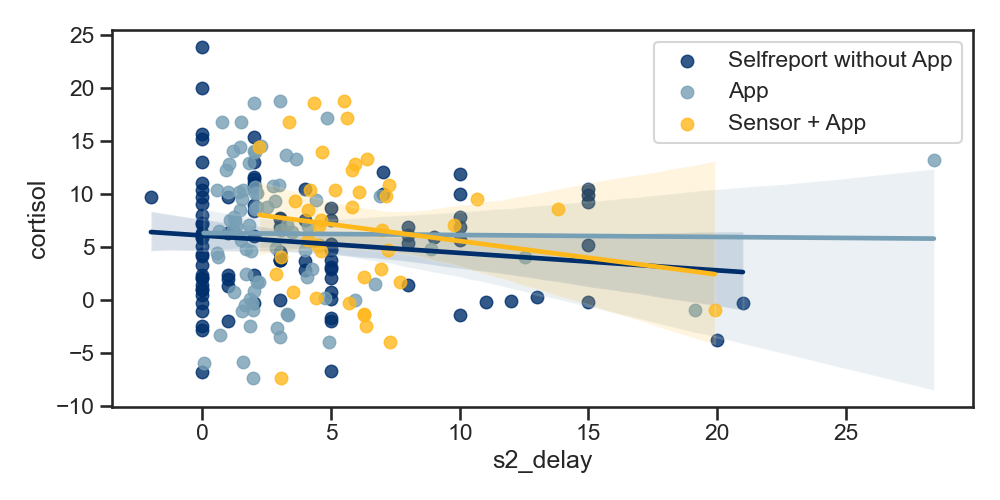

In [82]:
fig, ax = plt.subplots()

for log_type in ["Selfreport without App", "App", "Sensor + App"]:
    sns.regplot(
        data=cort_inc.xs(log_type, level="log_type").reset_index(), x="s2_delay", y="cortisol", ax=ax, label=log_type
    )
ax.legend()
fig.tight_layout()

## Export

In [76]:
bp.io.write_pandas_dict_excel(dict_saliva_export, result_path.joinpath("saliva_results.xlsx"))